Analysis the wind speed around the country with a view to windfarms

• You may look for your own source of historic weather information, and/or use the Met Eireann one (Historical Data - Met Éireann - The Irish Meteorological Service). Click on the download button to get a zip file that contains a CSV file.
• You may need to clean and normalize the data before doing analysis
• Questions you can ask:
o How much wind power is there at a particular location?
▪ This is quite open ended, is this just the mean wind speed for an hour/day/month/year, or should you take into account that
there are wind ranges that the windfarms can operate in. (min max speeds)
▪ Some analysis of what power when would be useful (time of day/year)
o Are the wind speeds likely to be the same in 10 years in the future? ie is there a trend in recorded wind speeds over the last few decades.
o Is there any other weather metric worth analyzing (eg rain, temp)
o What will the power output of the windfarms in Ireland be like next week, according to the weather forecasts? (ok that is a tricky one, because you would need to get, or make up, information about the size and locations of the wind farms in Ireland, one find/makeup the windspeed to power output equation.



Steps:

1/ Download data (hourly) from given website. 

2/ Upload the files on Github

3/ Clean the file

- Remove all the rows above the Index row from the raw files

- Remove all the rows before the row where wdsp has its first value

4/ Review the variable 'wdsp', convert the measurement of wind speed from knot into m/s

5/ Add column 'dateonly' that contains dates (date-month-year) and column 'month' that contains months (month-year)

Ref: Wind power calculation
https://en.wikipedia.org/wiki/Wind_power

Ref:
Wind turbines will generally operate between 7mph (11km/h) and 56mph (90km/h). The efficiency is usually maximised at about 18mph (29km/h) and they will reach their maximum output at 27mph (43km/h).

https://www.nationalgrid.com/stories/energy-explained/wind-power-questions-answered#:~:text=Do%20turbines%20need%20fast%20wind,27mph%20(43km/h).


# Step 1: Upload data

The historical data hourly of 23 stations is downloaded from given website https://www.met.ie/climate/available-data/historical-data and stored in folder 'data' 


# Step 2: Clean the data

As the raw data in folder 'data' still contains uneccessary information. I need to clean the data I need to clean the data with function file_with_station. It allows to:
- delete all unneccessary first rows of the csv file
- 

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt




For later calculation, I convert the measurement of wind speed from knot into m/s

In [49]:
def file_with_station(file,station):

    # -------- Delete uneccessary rows ------------------------------
    # Read file as text
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Find the row number where the data starts i.e. the row that contain 'date' in its first column
    header_row = None

    for i, line in enumerate(lines):
        # split on comma and strip spaces
        first_cell = line.split(",")[0].strip().lower()
        if first_cell == "date":
            header_row = i
            break

    # Read file as csv, delete uneccessary rows
    df = pd.read_csv(file, skiprows=header_row,low_memory=False)


    # --------- Keep only useful columns ----------------------------- 
    df = df[["date", "wdsp", "temp", "rain"]]

    # convert 'wdsp' to numeric
    df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

    # find first row where wind speed is not NaN
    first_valid_value = df.loc[(df["wdsp"].notna()) & (df["wdsp"] != 0)].index.min()

    # drop rows before that
    df = df.loc[first_valid_value:].reset_index(drop=True)


    # --------- Fill up missing value ----------------------------------
    # modify the format of 'date'
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

    # Set 'date' as index as interpolate based on actual time differences between index values
    df = df.set_index('date')

    # Interpolate missing windspeed (linear is best for meteorological data) -- I use AI to help me with this.
    df['wdsp'] = df['wdsp'].interpolate(method='time', limit_direction='both', limit_area='inside')

    
    # --------- Add new columns ---------------------------------------
    # Bring 'date' back as a column
    df = df.reset_index()

    # modify the format of 'date'
    #df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

    # Add a column that contains only date details
    df['dateonly']= df['date'].dt.date

    # Add a column that contains only year
    df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')

    # Add a column that contains only month-year
    df['yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

    # Add a column that contains only month
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%m')

    # Add a column that contains only hour
    df['hour'] = pd.to_datetime(df['date']).dt.strftime('%H:%M')

    # convert the measurement of wdsp into m/s
    df["wdsp_ms"] = df["wdsp"] * 0.5144444444

    # Add a column which takes the station name as value
    df["station"]= station

    # convert 'temp' to numeric
    df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    R = 287.05       # J/(kg·K)
    p = 101325       # Pa (assumed constant)
    # Add column 'rho' - air density
    df["rho"] = p / (R * (df["temp"] + 273.15))

    # Add column 'power' - wind power density
    df['power'] = 0.5 * df["rho"] * df["wdsp_ms"]**3


    # --------- Save as a new file in folder stationdata ----------------
    df.to_csv(f"stationdata/{station}.csv", index=False)
    print(f"The file {station}.csv is now created.")

In [16]:
file_with_station("data/hly275.csv","MACE HEAD")
file_with_station("data/hly375.csv","OAK PARK")
file_with_station("data/hly518.csv","SHANNON AIRPORT")
file_with_station("data/hly532.csv","DUBLIN AIRPORT")
file_with_station("data/hly575.csv","MOORE PARK")
file_with_station("data/hly675.csv","BALLYHAISE")
file_with_station("data/hly775.csv","SHERKIN ISLAND")
file_with_station("data/hly875.csv","MULLINGAR")
file_with_station("data/hly1075.csv","ROCHES POINT")
file_with_station("data/hly1175.csv","NEWPORT")
file_with_station("data/hly1375.csv","DUNSANY")
file_with_station("data/hly1475.csv","GURTEEN")
file_with_station("data/hly1575.csv","MALIN HEAD")
file_with_station("data/hly1775.csv","JOHNSTOWN CASTLE 2")
file_with_station("data/hly1875.csv","ATHENRY")
file_with_station("data/hly1975.csv","MT DILLON")
file_with_station("data/hly2075.csv","FINNER")
file_with_station("data/hly2175.csv","CLAREMORRIS")
file_with_station("data/hly2275.csv","VALENTIA OBSERVATORY")
file_with_station("data/hly2375.csv","BELMULLET")
file_with_station("data/hly3904.csv","CORK AIRPORT")
file_with_station("data/hly4935.csv","KNOCK AIRPORT")

The file MACE HEAD.csv is now created.
The file OAK PARK.csv is now created.
The file SHANNON AIRPORT.csv is now created.
The file DUBLIN AIRPORT.csv is now created.
The file MOORE PARK.csv is now created.
The file BALLYHAISE.csv is now created.
The file SHERKIN ISLAND.csv is now created.
The file MULLINGAR.csv is now created.
The file ROCHES POINT.csv is now created.
The file NEWPORT.csv is now created.
The file DUNSANY.csv is now created.
The file GURTEEN.csv is now created.
The file MALIN HEAD.csv is now created.
The file JOHNSTOWN CASTLE 2.csv is now created.
The file ATHENRY.csv is now created.
The file MT DILLON.csv is now created.
The file FINNER.csv is now created.
The file CLAREMORRIS.csv is now created.
The file VALENTIA OBSERVATORY.csv is now created.
The file BELMULLET.csv is now created.
The file CORK AIRPORT.csv is now created.
The file KNOCK AIRPORT.csv is now created.


In [50]:
file_with_station("data/hly375.csv","OAK PARK")

The file OAK PARK.csv is now created.


In [51]:
oakpark = pd.read_csv("stationdata/OAK PARK.csv")
oakpark.head()

/tmp/ipykernel_3643/4201213406.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  oakpark = pd.read_csv("stationdata/OAK PARK.csv")


,date,wdsp,temp,rain,dateonly,year,yearmonth,month,hour,wdsp_ms,station,rho,power
0,2003-08-13 09:00:00,6.0,17.3,0.0,2003-08-13,2003,2003-08,8,09:00,3.086667,OAK PARK,1.215312,17.870096
1,2003-08-13 10:00:00,6.0,18.5,0.0,2003-08-13,2003,2003-08,8,10:00,3.086667,OAK PARK,1.210311,17.796569
2,2003-08-13 11:00:00,5.0,19.3,0.0,2003-08-13,2003,2003-08,8,11:00,2.572222,OAK PARK,1.207000,10.270767
3,2003-08-13 12:00:00,5.0,20.4,0.0,2003-08-13,2003,2003-08,8,12:00,2.572222,OAK PARK,1.202478,10.232281
4,2003-08-13 13:00:00,6.0,20.9,0.0,2003-08-13,2003,2003-08,8,13:00,3.086667,OAK PARK,1.200433,17.651315


In [52]:
# count the number of missing values
oakpark["wdsp"].isna().sum()

np.int64(0)

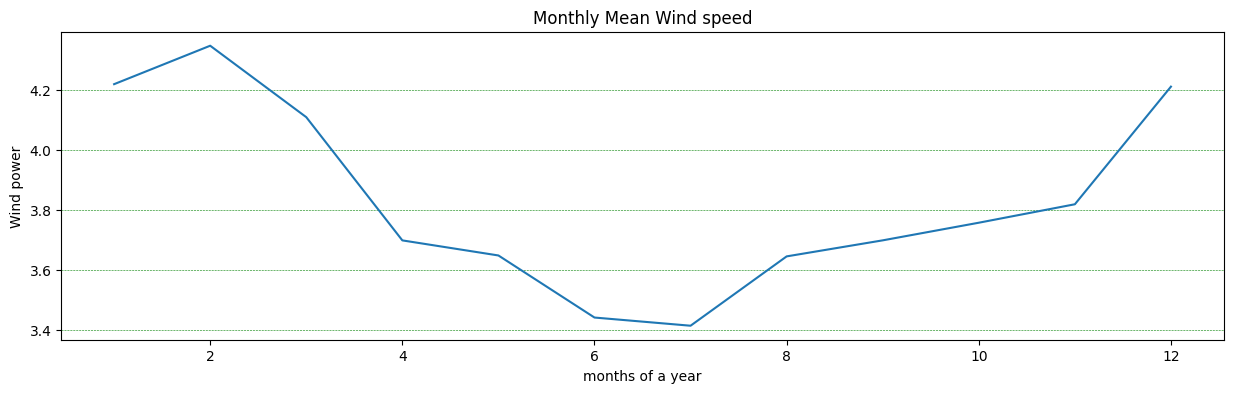

In [53]:
# Variation of wind speed by month
plt.figure(figsize=(15,4))
monthly_wdsp = oakpark.groupby("month")["wdsp_ms"].mean()
monthly_wdsp.plot(title="Monthly Mean Wind speed")
plt.xlabel('months of a year')
plt.ylabel('Wind power')
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.4)

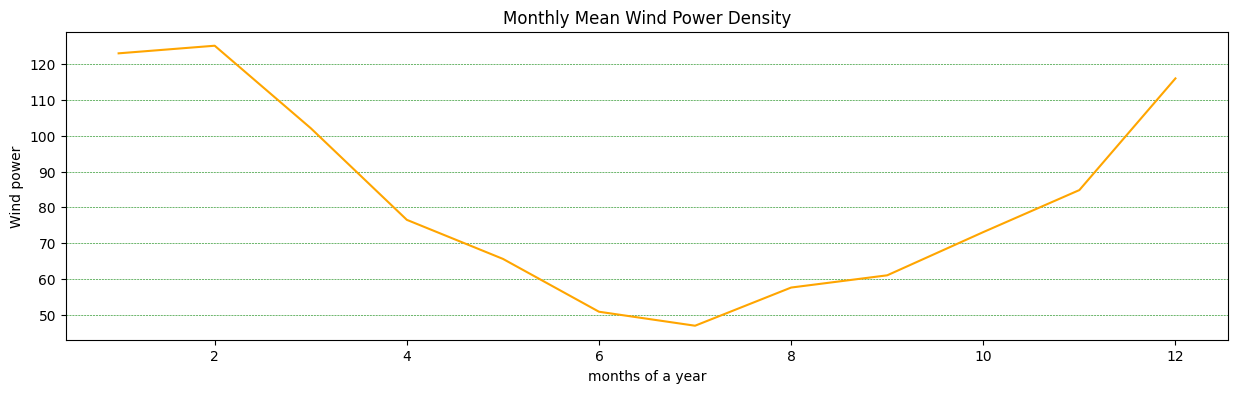

In [66]:
# Variation of power density by month
plt.figure(figsize=(15,4))
rho = 1.225  # air density kg/m^3
oakpark["power_density"] = 0.5 * rho * oakpark["wdsp_ms"]**3
#monthly_power_density = oakpark.groupby("month")["power_density"].mean()
monthly_power = oakpark.groupby("month")["power"].mean()
#monthly_power_density.plot(color='green')
monthly_power.plot(color='orange')
plt.title("Monthly Mean Wind Power Density")
plt.xlabel('months of a year')
plt.ylabel('Wind power')
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.4)

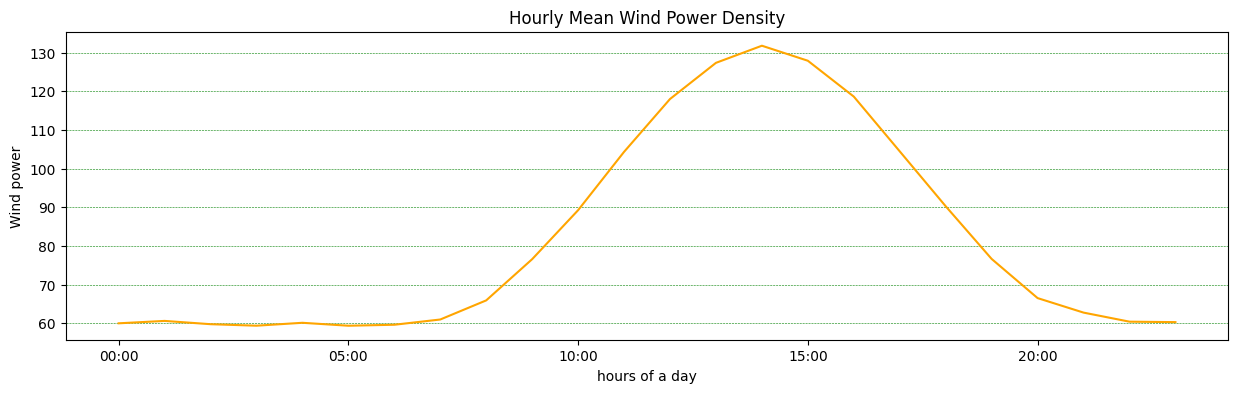

In [67]:
# variation of power density by hour
plt.figure(figsize=(15,4))
#hourly_power_density = oakpark.groupby("hour")["power_density"].mean()
hourly_power = oakpark.groupby("hour")["power"].mean()
#hourly_power_density.plot(color='green')
hourly_power.plot(color='orange')
plt.title("Hourly Mean Wind Power Density")
plt.xlabel('hours of a day')
plt.ylabel('Wind power')
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.4)

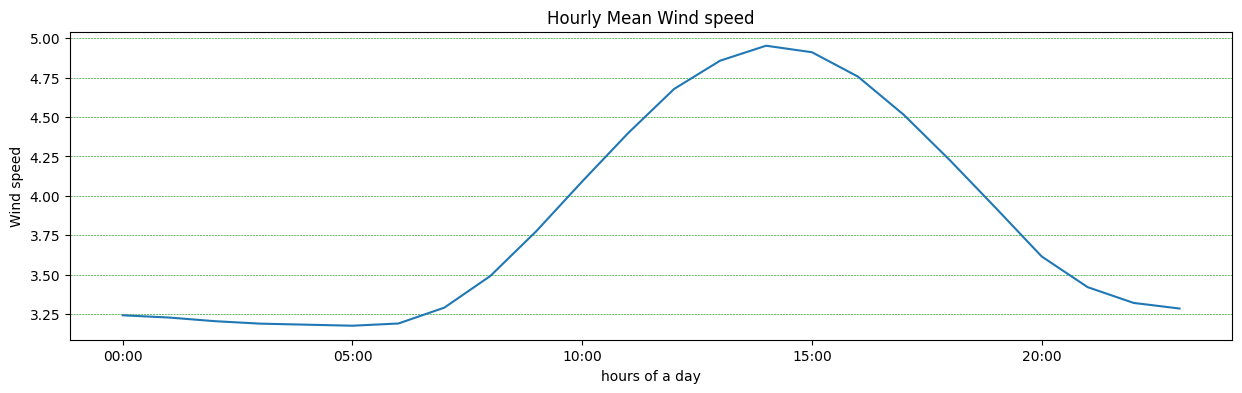

In [56]:
# Variation of wind speed by month
plt.figure(figsize=(15,4))
hourly_wdsp = oakpark.groupby("hour")["wdsp_ms"].mean()
hourly_wdsp.plot(title="Hourly Mean Wind speed")
plt.xlabel('hours of a day')
plt.ylabel('Wind speed')
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.4)

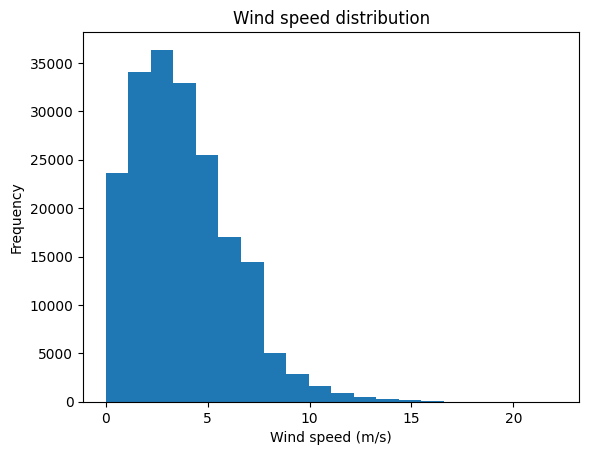

In [57]:
# Study wind speed range
plt.hist(oakpark["wdsp_ms"], bins=20)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Frequency")
plt.title("Wind speed distribution")
plt.show()

In [58]:
# Define the wind range
cut_in = 7
optimum = 18     
cut_out = 27 

In [59]:
# Study wind range for wind turbines operation
oakpark["operating"] = (oakpark["wdsp"] >= 7) & (oakpark["wdsp"] <= 27)
oakpark["optimal"]   = (oakpark["wdsp"] >= 12) & (oakpark["wdsp"] <= 18)

# number of hours per day that the wind speed is in the operating range
daily_hours = oakpark.groupby("dateonly")["operating"].sum()
daily_avg = daily_hours.mean()

daily_optimal = oakpark.groupby("dateonly")["optimal"].sum().mean()

print(f'{daily_avg} & {daily_optimal}')

12.411562538357678 & 3.5386031668098687


In [60]:
# number of hours per day that the wind speed is in the operating range
monthly_hours = oakpark.groupby("month")["operating"].sum()
monthly_avg = monthly_hours.mean()

monthly_optimal = oakpark.groupby("month")["optimal"].sum().mean()
print(f'{monthly_avg} & {monthly_optimal}')

8426.416666666666 & 2402.4166666666665


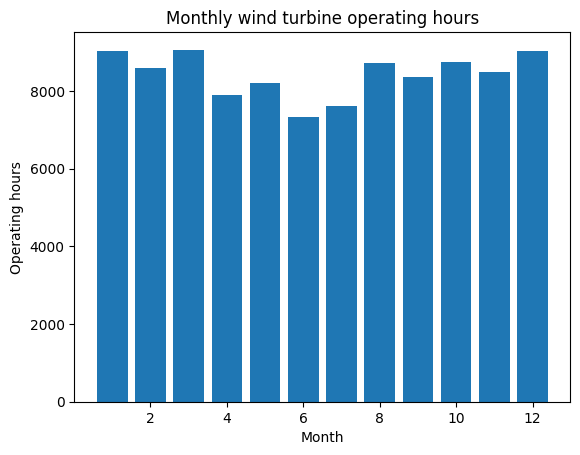

In [61]:
plt.bar(monthly_hours.index, monthly_hours.values)
plt.xlabel("Month")
plt.ylabel("Operating hours")
plt.title("Monthly wind turbine operating hours")
plt.show()

In [62]:
yearly_hours = oakpark.groupby("year")["operating"].sum()
yearly_avg = yearly_hours.mean()

yearly_optimal = oakpark.groupby("year")["optimal"].sum().mean()

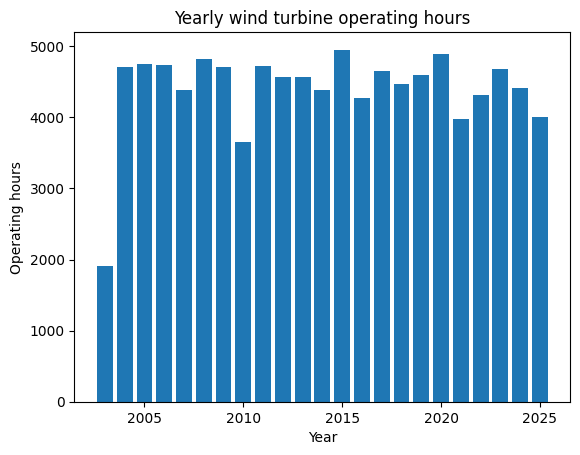

In [63]:
plt.bar(yearly_hours.index, yearly_hours.values)
plt.xlabel("Year")
plt.ylabel("Operating hours")
plt.title("Yearly wind turbine operating hours")
plt.show()

In [65]:
from pathlib import Path

data_dir = Path("data")

for file in data_dir.glob("*.csv"):
    size_mb = file.stat().st_size / (1024*1024)
    print(f"{file.name} size: {size_mb:.2f} MB")

hly1875.csv size: 8.68 MB
hly1075.csv size: 36.96 MB
hly518.csv size: 57.83 MB
hly3904.csv size: 46.00 MB
hly575.csv size: 12.28 MB
hly275.csv size: 12.37 MB
hly2375.csv size: 49.03 MB
hly875.csv size: 28.48 MB
hly775.csv size: 12.02 MB
hly1575.csv size: 49.83 MB
hly3723.csv size: 42.44 MB
hly675.csv size: 12.16 MB
hly4935.csv size: 20.74 MB
hly1775.csv size: 12.28 MB
hly375.csv size: 12.29 MB
hly1475.csv size: 9.84 MB
hly1975.csv size: 11.69 MB
hly1375.csv size: 10.78 MB
hly2075.csv size: 14.46 MB
hly532.csv size: 58.18 MB
hly2175.csv size: 41.72 MB
hly2275.csv size: 57.38 MB
hly1175.csv size: 11.53 MB


In [ ]:
# Folder contains all files with stations in column
DATADIR = Path("stationdata")
#STATIONINFO = "stationinfo.csv"
STUDYDATETILL2025 = "studydate.csv"

# Create a list 'stationlist'
stationlist = []

# In each file in folder 'stationdata'
for file in DATADIR.glob('*.csv'):
    # Read only 2 columns 'station' and 'date'
    df = pd.read_csv(file, usecols=["station", "date"])
    # Remove rows where 'date' is missing
    #df = df[df["date"].notna()]
    # Convert the column 'date' to datetime
    #df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Get the station's name by getting the first row value of column 'station'
    station_name = df["station"].iloc[0]
    # Get the start date of the station
    start_date = df["date"].min().strftime("%Y-%m-%d %H:%M:%S")
    # Get the end date of the station
    end_date = df["date"].max().strftime("%Y-%m-%d %H:%M:%S")
    
    # Write the infos above in 'stationlist'
    stationlist.append({
            "station": station_name,
            "startdate": start_date,
            "enddate": end_date
        })
# Save stationinfo.csv
stationinfo_df = pd.DataFrame(stationlist)

stationinfo_df.to_csv('stationinfo.csv', index=False)
print("stationinfo.csv is ready")


# Step 2: Generate datestudy.csv: the idea behind this step is to set the same start date and end date for all stations, 
# to make the comparison simpler for later?

# get the max start date among all stations
#max_start = stationinfo_df["startdate"].max()
# get the max end date among all stations
#max_end = stationinfo_df["enddate"].max()

# Data frame that contains all dates from max_start to max_end
#all_dates = pd.date_range(start=max_start, end=max_end, freq="h")

# Save to datetill2025.csv
#datestudy_df = pd.DataFrame({"date": all_dates})
#datestudy_df.to_csv('datestudy.csv', index=False)
#print("datestudy.csv is ready")

stationinfo.csv is ready
datestudy.csv is ready


In [16]:
stationinfo = pd.read_csv("stationinfo.csv")
# get the max start date among all stations
max_start = stationinfo["startdate"].max()

DATADIR = Path("stationdata")

# Create a list
sta_miss = []

for file in DATADIR.glob('*.csv'):
    # Read stations files
    station_df = pd.read_csv(file)

    # Keep only rows with dates in studydate.csv
    station_df = station_df[station_df["date"]>= max_start]
    
    # change the type on 'wdsp' to numeric, the missing value will be turned into NaN with parameter errors="coerce"
    station_df["wdsp"] = pd.to_numeric(station_df["wdsp"], errors="coerce")

    # count the number of missing values
    station_df["wdsp"].isna().sum()

    # Skip stations with no remaining data
    if station_df.empty:
        continue

    # Write the infos above in 'stationlist'
    sta_miss.append({
            "station": station_df["station"].iloc[0],
            "startdate": station_df["wdsp"].isna().sum()
        })
    
# Save stationinfo.csv
sta_miss_df = pd.DataFrame(sta_miss)
    # Save as a new file in folder stationdata
    #station_df.to_csv(file, index=False)
print(sta_miss_df)
    


/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (3,5,7,8,9,10,11,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(file)
/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(file)
/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (3,5,7,8,9,10,11,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(file)
/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (7,8,9,10,11,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(file)
/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (7,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(file)
/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (7,13,15) have mixe

                 station  startdate
0                DUNSANY         13
1              BELMULLET          1
2     JOHNSTOWN CASTLE 2         34
3            CLAREMORRIS        207
4               CASEMENT          4
5        SHANNON AIRPORT         12
6         DUBLIN AIRPORT          0
7           CORK AIRPORT          0
8           ROCHES POINT         18
9   VALENTIA OBSERVATORY         45
10            BALLYHAISE         28
11              OAK PARK          1
12             MULLINGAR         13
13            MOORE PARK          0
14         KNOCK AIRPORT          0
15             MACE HEAD         92
16             MT DILLON         62
17        SHERKIN ISLAND          5
18               NEWPORT         76
19            MALIN HEAD         52
20                FINNER       7421
21               ATHENRY         50
22               GURTEEN         35


/tmp/ipykernel_2567/3057289317.py:12: DtypeWarning: Columns (3,5,7,8,9,10,11,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(file)


In [3]:
df = pd.read_csv('datestudy.csv')
pd.api.types.is_datetime64_any_dtype(df["date"])

False

In [32]:
# change the type on 'wdsp' to numeric, the missing value will be turned into NaN with parameter errors="coerce"
df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

# count the number of missing values
df["wdsp"].isna().sum()

np.int64(24)